#**Training d-DNN and e-DNNs using CPR coincidences over the coast**

In [ ]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
import h5py
import os
from tensorflow.keras.utils import to_categorical
os.getcwd()

## **1. Data**

### **1.1 Data Loading and Organizing**

In [ ]:
f = h5py.File('Data/Dictionaries/Dic_CPR_coast.mat','r')
list(f.keys())

['X_coast_trn_detection',
 'X_coast_trn_retrieval',
 'X_coast_tst_detection',
 'X_coast_tst_retrieval',
 'y_coast_trn_detection',
 'y_coast_trn_retrieval',
 'y_coast_tst_detection',
 'y_coast_tst_retrieval']

In [ ]:
X1_trn_detection = np.transpose(f['X_coast_trn_detection'])
y_trn_detection = np.transpose(f['y_coast_trn_detection'])
X1_tst_detection = np.transpose(f['X_coast_tst_detection'])
y_tst_detection = np.transpose(f['y_coast_tst_detection'])

X1_trn_retrieval = np.transpose(f['X_coast_trn_retrieval'])
y_trn_retrieval = np.transpose(f['y_coast_trn_retrieval'])
X1_tst_retrieval = np.transpose(f['X_coast_tst_retrieval'])
y_tst_retrieval = np.transpose(f['y_coast_tst_retrieval'])

In [ ]:
X1_trn_detection.astype('float64')
X1_tst_detection.astype('float64')
y_trn_detection.astype('int64')
y_tst_detection.astype('int64')

X1_trn_retrieval.astype('float64')
X1_tst_retrieval.astype('float64')
y_trn_retrieval.astype('float64')
y_tst_retrieval.astype('float64');

### **1.2 Data Normalizing**

The input features for training have different ranges and units, therefore they need to be scaled to make the flow of the gradient decsent smooth and help the algorithm quickly reaches the optimal point of the cost function. Without scaling features, the algorithm may be biased toward those features which have larger magnitues. We used the following standardization:

$X_i^{\prime} = \frac{X_i - \mu}{σ}$

In the above equation $X_i^{\prime}$ is the scaled feature, $μ$ is the mean, and $σ$ is the standard deviation of the feature. In the next cell, we implement this scaling for the data sets.

In [ ]:
mean_detection = X1_trn_detection.mean(axis=0)
X2_trn_detection = X1_trn_detection-mean_detection
std_detection = X1_trn_detection.std(axis=0)
X_trn_detection = X2_trn_detection/std_detection
X2_tst_detection = X1_tst_detection-mean_detection
X_tst_detection = X2_tst_detection/std_detection

mean_retrieval = X1_trn_retrieval.mean(axis=0)
X2_trn_retrieval = X1_trn_retrieval-mean_retrieval
std_retrieval = X1_trn_retrieval.std(axis=0)
X_trn_retrieval = X2_trn_retrieval/std_retrieval
X2_tst_retrieval = X1_tst_retrieval-mean_retrieval
X_tst_retrieval = X2_tst_retrieval/std_retrieval

To show that the labels are balanced in the training and test set, the number of snowfall, rainfall and no precipitation lables is printed in the next cell.

In [ ]:

print('***Training Dataset:\n')

n_snow=1
n_rain=1
n_clear=1  
t_train = np.zeros([y_trn_detection.shape[0],1])

for i in range(len(X_trn_detection)):
    label = y_trn_detection[i]
    if label==5:
        n_snow+=1
        t_train[i]=2
    if label==3:
        n_rain+=1  
        t_train[i]=1
    if label==0:
        n_clear+=1
        t_train[i]=0
        
print('Num. of snowfall:',n_snow)
print('Num. of rainfall:',n_rain)
print('Num. of clear-sky:',n_clear)

print('\n***Testing Dataset:\n')

n_snow=1
n_rain=1
n_clear=1  
t_test = np.zeros([y_tst_detection.shape[0],1])

for i in range(len(X_tst_detection)):
    label = y_tst_detection[i]
    if label==5:
        n_snow+=1
        t_test[i]=2
    if label==3:
        n_rain+=1  
        t_test[i]=1
    if label==0:
        n_clear+=1
        t_test[i]=0
        
print('Num. of snowfall:',n_snow)
print('Num. of rainfall:',n_rain)
print('Num. of clear-sky:',n_clear)

***Training Dataset:

Num. of snowfall: 1929
Num. of rainfall: 1978
Num. of clear-sky: 3882

***Testing Dataset:

Num. of snowfall: 848
Num. of rainfall: 807
Num. of clear-sky: 1683


In [ ]:
# Change the labels to catagorical
t_trn_detection = to_categorical(t_train)
t_tst_detection = to_categorical(t_test)

# **2. Training the networks**

### **2.1 - Detection Network (d-DNN)**

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import layers, Sequential

In [ ]:
# Defining the architecture of the d-DNN network which has 6 layers and 30 hidden units in each layer.

# Parameters
hidden_units = 30
dropout = 0

# Detection Module
model_detection = Sequential()

model_detection.add(Dense(hidden_units))
model_detection.add(Activation('relu'))
model_detection.add(Dropout(dropout))

model_detection.add(Dense(hidden_units))
model_detection.add(Activation('relu'))
model_detection.add(Dropout(dropout))

model_detection.add(Dense(hidden_units))
model_detection.add(Activation('relu'))
model_detection.add(Dropout(dropout))

model_detection.add(Dense(hidden_units))
model_detection.add(Activation('relu'))
model_detection.add(Dropout(dropout))

model_detection.add(Dense(hidden_units))
model_detection.add(Activation('relu'))
model_detection.add(Dropout(dropout))

model_detection.add(Dense(hidden_units))
model_detection.add(Activation('relu'))
model_detection.add(Dropout(dropout))

model_detection.add(Dense(3))
model_detection.add(Activation('softmax'))

In [ ]:
# Compiling the model by defining the loss function and learning rate.
model_detection.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics= [tf.keras.metrics.Recall()])

In [ ]:
# Defining the callback list for early stoping and saving the model.
from tensorflow import keras
callbacks_list = [
     keras.callbacks.EarlyStopping(
     monitor="val_loss",
     patience=20,),
    keras.callbacks.ModelCheckpoint(
    filepath="checkpoint_path.keras",
    monitor="val_loss",
    save_best_only=True,
    )    
]

In [ ]:
# Training the network (batch_size= 40, epoch = 300)
print('\nFitting DNN (Detection Module):\n')
batch_size1 = 40
history_detection = model_detection.fit(X_trn_detection, t_trn_detection, epochs=300,
                                validation_split=.2, batch_size = batch_size1,
                                callbacks=callbacks_list, verbose=1)


Fitting DNN (Detection Module):

Epoch 1/300
156/156 [==============================] - 0s 2ms/step - loss: 1.0192 - recall: 0.0389 - val_loss: 0.9190 - val_recall: 0.1746
Epoch 2/300
156/156 [==============================] - 0s 940us/step - loss: 0.8288 - recall: 0.2728 - val_loss: 0.7160 - val_recall: 0.4050
Epoch 3/300
156/156 [==============================] - 0s 892us/step - loss: 0.6473 - recall: 0.5156 - val_loss: 0.5426 - val_recall: 0.6566
Epoch 4/300
156/156 [==============================] - 0s 891us/step - loss: 0.4737 - recall: 0.7506 - val_loss: 0.3881 - val_recall: 0.8614
Epoch 5/300
156/156 [==============================] - 0s 909us/step - loss: 0.3441 - recall: 0.8744 - val_loss: 0.3033 - val_recall: 0.8935
Epoch 6/300
156/156 [==============================] - 0s 911us/step - loss: 0.2839 - recall: 0.8964 - val_loss: 0.2683 - val_recall: 0.9121
Epoch 7/300
156/156 [==============================] - 0s 904us/step - loss: 0.2568 - recall: 0.9049 - val_loss: 0.2514 - 

156/156 [==============================] - 0s 908us/step - loss: 0.1409 - recall: 0.9461 - val_loss: 0.1443 - val_recall: 0.9435
Epoch 59/300
156/156 [==============================] - 0s 799us/step - loss: 0.1391 - recall: 0.9473 - val_loss: 0.1468 - val_recall: 0.9435
Epoch 60/300
156/156 [==============================] - 0s 870us/step - loss: 0.1390 - recall: 0.9475 - val_loss: 0.1433 - val_recall: 0.9442
Epoch 61/300
156/156 [==============================] - 0s 754us/step - loss: 0.1380 - recall: 0.9467 - val_loss: 0.1436 - val_recall: 0.9461
Epoch 62/300
156/156 [==============================] - 0s 877us/step - loss: 0.1383 - recall: 0.9486 - val_loss: 0.1419 - val_recall: 0.9461
Epoch 63/300
156/156 [==============================] - 0s 761us/step - loss: 0.1364 - recall: 0.9493 - val_loss: 0.1457 - val_recall: 0.9499
Epoch 64/300
156/156 [==============================] - 0s 754us/step - loss: 0.1369 - recall: 0.9491 - val_loss: 0.1439 - val_recall: 0.9461
Epoch 65/300
156/15

Epoch 116/300
156/156 [==============================] - 0s 780us/step - loss: 0.1149 - recall: 0.9573 - val_loss: 0.1303 - val_recall: 0.9538
Epoch 117/300
156/156 [==============================] - 0s 912us/step - loss: 0.1150 - recall: 0.9566 - val_loss: 0.1291 - val_recall: 0.9538
Epoch 118/300
156/156 [==============================] - 0s 754us/step - loss: 0.1143 - recall: 0.9571 - val_loss: 0.1316 - val_recall: 0.9525
Epoch 119/300
156/156 [==============================] - 0s 742us/step - loss: 0.1141 - recall: 0.9581 - val_loss: 0.1316 - val_recall: 0.9512
Epoch 120/300
156/156 [==============================] - 0s 742us/step - loss: 0.1137 - recall: 0.9575 - val_loss: 0.1312 - val_recall: 0.9512
Epoch 121/300
156/156 [==============================] - 0s 742us/step - loss: 0.1135 - recall: 0.9586 - val_loss: 0.1335 - val_recall: 0.9480
Epoch 122/300
156/156 [==============================] - 0s 742us/step - loss: 0.1126 - recall: 0.9584 - val_loss: 0.1292 - val_recall: 0.9538

156/156 [==============================] - 0s 748us/step - loss: 0.0988 - recall: 0.9639 - val_loss: 0.1336 - val_recall: 0.9493
Epoch 174/300
156/156 [==============================] - 0s 754us/step - loss: 0.0986 - recall: 0.9647 - val_loss: 0.1290 - val_recall: 0.9544
Epoch 175/300
156/156 [==============================] - 0s 786us/step - loss: 0.0988 - recall: 0.9658 - val_loss: 0.1279 - val_recall: 0.9519
Epoch 176/300
156/156 [==============================] - 0s 900us/step - loss: 0.0982 - recall: 0.9647 - val_loss: 0.1266 - val_recall: 0.9544
Epoch 177/300
156/156 [==============================] - 0s 761us/step - loss: 0.0980 - recall: 0.9652 - val_loss: 0.1281 - val_recall: 0.9538
Epoch 178/300
156/156 [==============================] - 0s 761us/step - loss: 0.0976 - recall: 0.9650 - val_loss: 0.1278 - val_recall: 0.9551
Epoch 179/300
156/156 [==============================] - 0s 754us/step - loss: 0.0970 - recall: 0.9652 - val_loss: 0.1281 - val_recall: 0.9531
Epoch 180/300

156/156 [==============================] - 0s 806us/step - loss: 0.0860 - recall: 0.9690 - val_loss: 0.1307 - val_recall: 0.9576
Epoch 231/300
156/156 [==============================] - 0s 748us/step - loss: 0.0857 - recall: 0.9693 - val_loss: 0.1314 - val_recall: 0.9531
Epoch 232/300
156/156 [==============================] - 0s 754us/step - loss: 0.0857 - recall: 0.9682 - val_loss: 0.1318 - val_recall: 0.9551
Epoch 233/300
156/156 [==============================] - 0s 742us/step - loss: 0.0855 - recall: 0.9695 - val_loss: 0.1292 - val_recall: 0.9576
Epoch 234/300
156/156 [==============================] - 0s 818us/step - loss: 0.0847 - recall: 0.9706 - val_loss: 0.1303 - val_recall: 0.9551
Epoch 235/300
156/156 [==============================] - 0s 735us/step - loss: 0.0850 - recall: 0.9697 - val_loss: 0.1300 - val_recall: 0.9551
Epoch 236/300
156/156 [==============================] - 0s 742us/step - loss: 0.0841 - recall: 0.9706 - val_loss: 0.1303 - val_recall: 0.9538
Epoch 237/300

156/156 [==============================] - 0s 748us/step - loss: 0.0745 - recall: 0.9759 - val_loss: 0.1328 - val_recall: 0.9564
Epoch 288/300
156/156 [==============================] - 0s 742us/step - loss: 0.0738 - recall: 0.9764 - val_loss: 0.1366 - val_recall: 0.9570
Epoch 289/300
156/156 [==============================] - 0s 742us/step - loss: 0.0738 - recall: 0.9761 - val_loss: 0.1324 - val_recall: 0.9570
Epoch 290/300
156/156 [==============================] - 0s 735us/step - loss: 0.0739 - recall: 0.9751 - val_loss: 0.1326 - val_recall: 0.9564
Epoch 291/300
156/156 [==============================] - 0s 742us/step - loss: 0.0730 - recall: 0.9769 - val_loss: 0.1336 - val_recall: 0.9544
Epoch 292/300
156/156 [==============================] - 0s 748us/step - loss: 0.0730 - recall: 0.9764 - val_loss: 0.1379 - val_recall: 0.9596
Epoch 293/300
156/156 [==============================] - 0s 748us/step - loss: 0.0726 - recall: 0.9764 - val_loss: 0.1353 - val_recall: 0.9576
Epoch 294/300

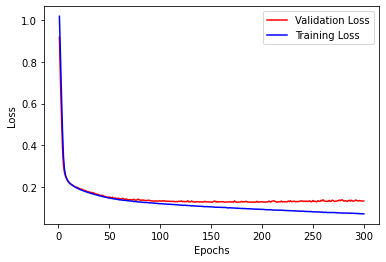

In [ ]:
# Plotting the variation of loss function on both training and validation set: 
import matplotlib.pyplot as plt

val_loss = history_detection.history["val_loss"]
loss = history_detection.history["loss"]

epochs = range(1, 301)
plt.plot(epochs, val_loss[:], "r-",
label="Validation Loss")
plt.plot(epochs, loss[:], "b-",
label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [ ]:
# Testin the trained network over the testset.
predictions_label = model_detection.predict(X_tst_detection)

# Using argmax function to select the label with the highest probability.
y_pred = np.zeros([len(X_tst_detection),1])
for i in range(len(X_tst_detection)):
    y_pred[i,0] = np.argmax(predictions_label[i])

### Metrics

In [ ]:
### Detection Module

n_cc=1
n_cs=1
n_cr=1
n_sc=1
n_ss=1
n_sr=1
n_rc=1
n_rs=1
n_rr=1

precip_c= 0
precip_r= 1
precip_s= 2

for i in range(len(X_tst_detection)):
    label_predict = y_pred[i]
    label_actual = t_test[i]
    if label_predict==precip_c and label_actual==precip_c:
        n_cc+=1
    if label_predict==precip_s and label_actual==precip_s:
        n_ss+=1
    if label_predict==precip_r and label_actual==precip_r:
        n_rr+=1 
    if label_predict==precip_c and label_actual==precip_s:
        n_cs+=1
    if label_predict==precip_c and label_actual==precip_r:
        n_cr+=1
    if label_predict==precip_s and label_actual==precip_c:
        n_sc+=1
    if label_predict==precip_s and label_actual==precip_r:
        n_sr+=1  
    if label_predict==precip_r and label_actual==precip_c:
        n_rc+=1
    if label_predict==precip_r and label_actual==precip_s:
        n_rs+=1        
        
#Snow
TP_s = n_ss
TN_s = n_cc+n_cr+n_rc+n_rr
FP_s = n_sc+n_sr
FN_s = n_cs+n_rs

precision_s = TP_s/(TP_s+FP_s)
acc_s = (TP_s+TN_s)/(TP_s+TN_s+FP_s+FN_s)
recall_s = TP_s/(TP_s+FN_s)
f1_score_s = (2*precision_s*recall_s)/(precision_s+recall_s)
FPR_s = FP_s/(FP_s+TN_s)

#Rain
TP_r = n_rr
TN_r = n_cc+n_cs+n_sc+n_ss
FP_r = n_rc+n_rs
FN_r = n_cr+n_sr

precision_r = TP_r/(TP_r+FP_r)
acc_r = (TP_r+TN_r)/(TP_r+TN_r+FP_r+FN_r)
recall_r = TP_r/(TP_r+FN_r)
f1_score_r = (2*precision_r*recall_r)/(precision_r+recall_r)
FPR_r = FP_r/(FP_r+TN_r) 

print('\n For Rainfall Detection Over Coast:\n')
print('Precision: ',precision_r)
print('Accuracy: ',acc_r)
print('Recall (TPR): ',recall_r)
print('False Alarm (FPR): ',FPR_r)
print('\nF1 Score: ',f1_score_r)

print('----------------------------')
print('\n For Snwofall Detection Over Coast:\n')
print('Precision: ',precision_s)
print('Accuracy: ',acc_s)
print('Recall (TPR): ',recall_s)
print('False Alarm (FPR): ',FPR_s)
print('\nF1 Score: ',f1_score_s)

#Model
TP = n_cc+n_ss+n_rr
FP = n_cs+n_cr+n_sc+n_sr+n_rc+n_rs
FN = n_sc+n_rc+n_cs+n_rs+n_cr+n_sr

precision = TP/(TP+FP)
recall = TP/(TP+FN)
f1_score = (2*precision*recall)/(precision+recall)

print('----------------------------')
print('\n For Model Detection Over Coast:\n')
print('Precision: ',precision)
print('Recall (TPR): ',recall)
print('\nF1 Score: ',f1_score)


 For Rainfall Detection Over Coast:

Precision:  0.9443757725587144
Accuracy:  0.9730861244019139
Recall (TPR):  0.9443757725587144
False Alarm (FPR):  0.01775147928994083

F1 Score:  0.9443757725587144
----------------------------

 For Snwofall Detection Over Coast:

Precision:  0.9551208285385501
Accuracy:  0.9823564593301436
Recall (TPR):  0.9764705882352941
False Alarm (FPR):  0.015637530072173216

F1 Score:  0.9656777196044211
----------------------------

 For Model Detection Over Coast:

Precision:  0.9563397129186603
Recall (TPR):  0.9563397129186603

F1 Score:  0.9563397129186603


In [ ]:
model_detection.evaluate(X_tst_detection, t_tst_detection, batch_size = batch_size1)

84/84 [==============================] - 0s 404us/step - loss: 0.1504 - recall: 0.9580


[0.150408536195755, 0.9580209851264954]

## **2.2 - Estimation networks (e-DNN)**

In [ ]:
from tensorflow.keras import backend
def root_mean_squared_error(y_true, y_pred):
        return backend.sqrt(backend.mean(backend.square(y_pred-y_true)))
    
def mean_absolute_error(y_true, y_pred):
        return backend.mean(backend.abs(y_pred-y_true))        

### **2.2.1 Snowfall retrieval**

In [ ]:
# Parameters
hidden_units = 60
dropout = 0

# LAND
model_retrieval = Sequential()

model_retrieval.add(Dense(hidden_units))
model_retrieval.add(Activation('relu'))
model_retrieval.add(Dropout(dropout))

model_retrieval.add(Dense(hidden_units))
model_retrieval.add(Activation('relu'))
model_retrieval.add(Dropout(dropout))

model_retrieval.add(Dense(hidden_units))
model_retrieval.add(Activation('relu'))
model_retrieval.add(Dropout(dropout))

model_retrieval.add(Dense(hidden_units))
model_retrieval.add(Activation('relu'))
model_retrieval.add(Dropout(dropout))

model_retrieval.add(Dense(hidden_units))
model_retrieval.add(Activation('relu'))
model_retrieval.add(Dropout(dropout))

model_retrieval.add(Dense(hidden_units))
model_retrieval.add(Activation('relu'))
model_retrieval.add(Dropout(dropout))

model_retrieval.add(Dense(1))
model_retrieval.add(Activation('relu'))

In [ ]:
model_retrieval.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00001),
              loss = root_mean_squared_error,
              metrics= mean_absolute_error)

In [ ]:
from tensorflow import keras
callbacks_list = [
#     keras.callbacks.EarlyStopping(
#     monitor="val_loss",
#     patience=20,),
    keras.callbacks.ModelCheckpoint(
    filepath="checkpoint_path.keras",
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    )    
]

In [ ]:
print('\nFitting DNN (Retrieval Module - Snow):\n')
batch_size2 = 40
history_retrieval = model_retrieval.fit(X_trn_retrieval, y_trn_retrieval, epochs=300,
                                validation_split=.2, batch_size = batch_size2,
                                callbacks=callbacks_list, verbose=1)


Fitting DNN (Retrieval Module - Snow):

Epoch 1/300
156/156 [==============================] - 13s 24ms/step - loss: 0.2505 - mean_absolute_error: 0.2092 - val_loss: 0.2028 - val_mean_absolute_error: 0.1671
Epoch 2/300
156/156 [==============================] - 1s 6ms/step - loss: 0.2004 - mean_absolute_error: 0.1471 - val_loss: 0.1626 - val_mean_absolute_error: 0.1154
Epoch 3/300
156/156 [==============================] - 1s 6ms/step - loss: 0.1723 - mean_absolute_error: 0.1069 - val_loss: 0.1403 - val_mean_absolute_error: 0.0828
Epoch 4/300
156/156 [==============================] - 1s 8ms/step - loss: 0.1561 - mean_absolute_error: 0.0824 - val_loss: 0.1286 - val_mean_absolute_error: 0.0655
Epoch 5/300
156/156 [==============================] - 1s 6ms/step - loss: 0.1477 - mean_absolute_error: 0.0702 - val_loss: 0.1218 - val_mean_absolute_error: 0.0558
Epoch 6/300
156/156 [==============================] - 1s 8ms/step - loss: 0.1417 - mean_absolute_error: 0.0630 - val_loss: 0.1176 -

156/156 [==============================] - 1s 6ms/step - loss: 0.0716 - mean_absolute_error: 0.0247 - val_loss: 0.0720 - val_mean_absolute_error: 0.0254
Epoch 100/300
156/156 [==============================] - 1s 6ms/step - loss: 0.0724 - mean_absolute_error: 0.0247 - val_loss: 0.0720 - val_mean_absolute_error: 0.0253
Epoch 101/300
156/156 [==============================] - 1s 6ms/step - loss: 0.0711 - mean_absolute_error: 0.0247 - val_loss: 0.0719 - val_mean_absolute_error: 0.0252
Epoch 102/300
156/156 [==============================] - 1s 5ms/step - loss: 0.0712 - mean_absolute_error: 0.0245 - val_loss: 0.0717 - val_mean_absolute_error: 0.0253
Epoch 103/300
156/156 [==============================] - 1s 4ms/step - loss: 0.0712 - mean_absolute_error: 0.0246 - val_loss: 0.0720 - val_mean_absolute_error: 0.0252
Epoch 104/300
156/156 [==============================] - 1s 5ms/step - loss: 0.0719 - mean_absolute_error: 0.0245 - val_loss: 0.0717 - val_mean_absolute_error: 0.0252
Epoch 105/30

Epoch 197/300
156/156 [==============================] - 1s 4ms/step - loss: 0.0622 - mean_absolute_error: 0.0207 - val_loss: 0.0696 - val_mean_absolute_error: 0.0232
Epoch 198/300
156/156 [==============================] - 1s 4ms/step - loss: 0.0621 - mean_absolute_error: 0.0207 - val_loss: 0.0700 - val_mean_absolute_error: 0.0232
Epoch 199/300
156/156 [==============================] - 1s 4ms/step - loss: 0.0620 - mean_absolute_error: 0.0207 - val_loss: 0.0694 - val_mean_absolute_error: 0.0233
Epoch 200/300
156/156 [==============================] - 1s 4ms/step - loss: 0.0621 - mean_absolute_error: 0.0207 - val_loss: 0.0697 - val_mean_absolute_error: 0.0232
Epoch 201/300
156/156 [==============================] - 1s 4ms/step - loss: 0.0616 - mean_absolute_error: 0.0206 - val_loss: 0.0695 - val_mean_absolute_error: 0.0231
Epoch 202/300
156/156 [==============================] - 1s 4ms/step - loss: 0.0617 - mean_absolute_error: 0.0206 - val_loss: 0.0695 - val_mean_absolute_error: 0.023

156/156 [==============================] - 1s 5ms/step - loss: 0.0588 - mean_absolute_error: 0.0196 - val_loss: 0.0696 - val_mean_absolute_error: 0.0229
Epoch 247/300
156/156 [==============================] - 1s 4ms/step - loss: 0.0592 - mean_absolute_error: 0.0196 - val_loss: 0.0692 - val_mean_absolute_error: 0.0227
Epoch 248/300
156/156 [==============================] - 1s 5ms/step - loss: 0.0604 - mean_absolute_error: 0.0196 - val_loss: 0.0692 - val_mean_absolute_error: 0.0227
Epoch 249/300
156/156 [==============================] - 1s 6ms/step - loss: 0.0594 - mean_absolute_error: 0.0196 - val_loss: 0.0695 - val_mean_absolute_error: 0.0227
Epoch 250/300
156/156 [==============================] - 1s 5ms/step - loss: 0.0594 - mean_absolute_error: 0.0195 - val_loss: 0.0694 - val_mean_absolute_error: 0.0227
Epoch 251/300
156/156 [==============================] - 1s 5ms/step - loss: 0.0599 - mean_absolute_error: 0.0195 - val_loss: 0.0694 - val_mean_absolute_error: 0.0228
Epoch 252/30

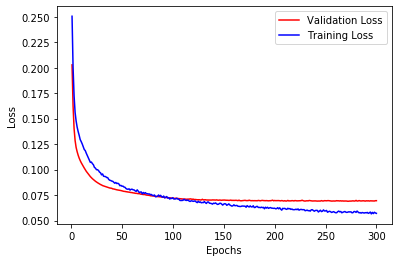

In [ ]:
val_loss = history_retrieval.history["val_loss"]
loss = history_retrieval.history["loss"]

epochs = range(1, 301)
plt.plot(epochs, val_loss[:], "r-",
label="Validation Loss")
plt.plot(epochs, loss[:], "b-",
label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [ ]:
predictions_snow = model_retrieval.predict(X_tst_retrieval)

### Evaluation

In [ ]:
model_retrieval.evaluate(X_tst_retrieval, y_tst_retrieval, batch_size = batch_size2)

84/84 [==============================] - 0s 2ms/step - loss: 0.0964 - mean_absolute_error: 0.0346


[0.09644481539726257, 0.03464727848768234]

# **3. Saving the models**

In [ ]:
import scipy
from scipy.io import savemat

model_detection.save('Models\CPR\Coast\model_dtc',save_format='h5')
model_retrieval.save('Models\CPR\Coast\model_snow',save_format='h5')

fp_CPR_coast = 'Models/CPR/coast/files_CPR_coast.mat'
scipy.io.savemat(fp_CPR_coast, {'mean_detection_CPR_coast': mean_detection,'std_detection_CPR_coast':std_detection,
                               'mean_snow_retrieval_CPR_coast': mean_retrieval,'std_snow_retrieval_CPR_coast':std_retrieval})